In [155]:
from importlib import reload
import sys
import os
sys.path.append(os.path.abspath('../'))
import util
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [156]:
prices = util.load_all_price_data(1).iloc[:60000]
squid_vwap = util.get_vwap(prices, 'SQUID_INK')
log_ret = np.log(squid_vwap).diff().dropna()

In [157]:
def cmma(squid_vwap, lookback=10):
    """
    Compute the cumulative moving average of the squid vwap.
    """
    raw_cmma = (squid_vwap - squid_vwap.rolling(lookback).mean().shift(1)).divide(np.sqrt(lookback+1)).dropna()
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))
    
    return sigmoid(raw_cmma) 


def relative_entropy_binned(data: pd.Series, num_bins: int) -> float:
    # Compute histogram: counts and bin edges
    counts, bin_edges = np.histogram(data, bins=num_bins)
    # Normalize counts to create a probability distribution (p)
    total = counts.sum()
    if total == 0:
        raise ValueError("The data series is empty or contains no values within the bins.")
    p = counts / total
    entropy = -np.sum(p * np.log(p + 1e-10))  # Adding a small value to avoid log(0)
    
    return entropy/np.log(num_bins)


<Axes: title={'center': 'CMMA'}, xlabel='timestamp'>

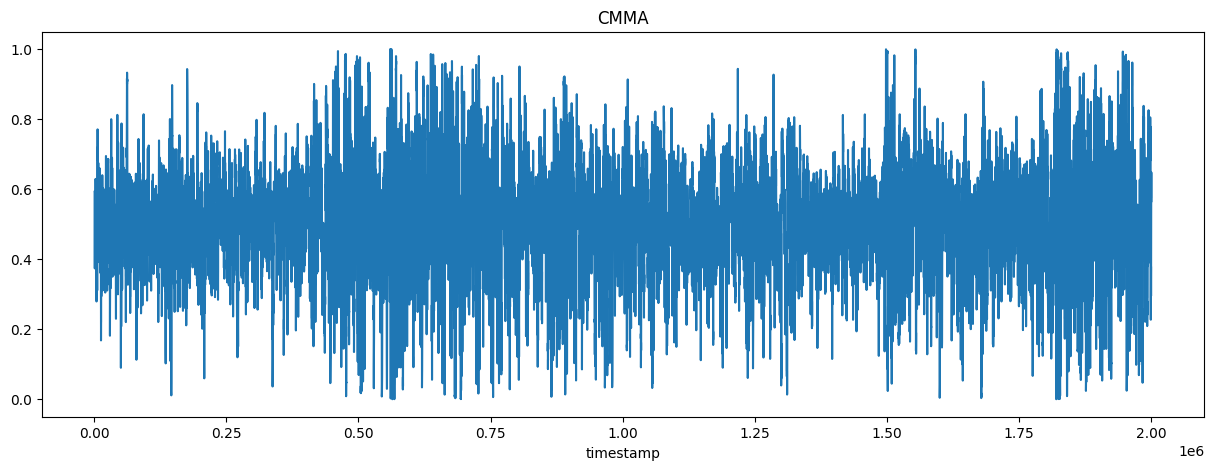

In [158]:
cmma(squid_vwap, 10).plot(title='CMMA', figsize=(15, 5))

0.8293110836836416


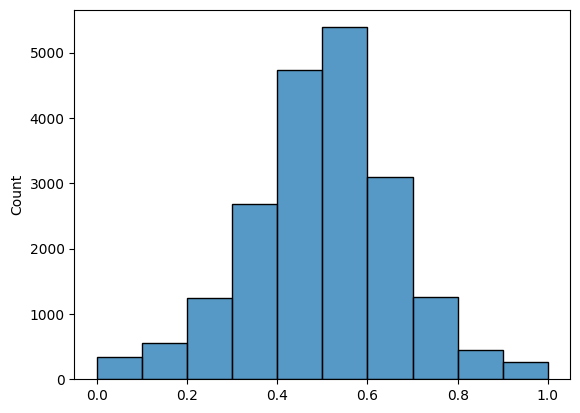

In [159]:
squid_cmma = cmma(squid_vwap,10)
p = print
p(relative_entropy_binned(squid_cmma,10))
sns.histplot(squid_cmma.values, bins=10)
plt.show()

In [160]:
def get_portfolio(signal_series, long_threshold, short_threshold):
    """
    Get portfolio based on signal series.
    """
    portfolio = pd.Series(index=signal_series.index, dtype=float)
    portfolio[signal_series > long_threshold] = 1  # Long position
    portfolio[signal_series < short_threshold] = -1  # Short position
    portfolio.fillna(0, inplace=True)  # No position
    return portfolio
def get_returns(returns, portfolio, tc = 1.5/2000):
    """
    Get returns based on portfolio.
    """
    to = abs(portfolio.diff())
    portfolio_returns = portfolio.shift(1) * returns- to * tc
    return portfolio_returns.dropna()

In [161]:
def get_performance_table(signal, returns):
    thresholds = np.linspace(0.01, 0.99, 98)
    sigmax, sigmin = signal.max(), signal.min()
    performance_data = []
    
    for threshold_frac in thresholds:
        threshold = np.quantile(signal, threshold_frac)
        buy_portfolio = get_portfolio(signal, threshold, sigmin)
        buy_returns = get_returns(returns, buy_portfolio)
        buy_cum_returns = (buy_returns).sum()
        sell_portfolio = -get_portfolio(signal, threshold, sigmin)
        sell_returns = get_returns(returns, sell_portfolio)
        sell_cum_returns = (sell_returns).sum()

        sellless_portfolio = get_portfolio(signal, sigmax, threshold)
        sellless_returns = get_returns(returns, sellless_portfolio)
        sellless_cum_returns = (sellless_returns).sum()
        buyless_portfolio = -get_portfolio(signal, sigmax, threshold)
        buyless_returns = get_returns(returns, buyless_portfolio)   
        buyless_cum_returns = (buyless_returns).sum()

        performance_data.append({
            'Threshold': threshold,
            'FracGreater': threshold_frac,
            'LongTotRet': buy_cum_returns,
            'ShortTotRet': sell_cum_returns,
            'FracLess': 1-threshold_frac,
            'Long2TotRet': buyless_cum_returns,
            'Short2TotRet': sellless_cum_returns
        })
    performance_df = pd.DataFrame(performance_data)
    return performance_df
cmma_performance = round(get_performance_table(squid_cmma, log_ret),2)
        

In [162]:
cmma_performance

,Threshold,FracGreater,LongTotRet,ShortTotRet,FracLess,Long2TotRet,Short2TotRet
0,0.06,0.01,-0.14,-0.06,0.99,-0.07,-0.13
1,0.12,0.02,-0.20,-0.18,0.98,-0.20,-0.19
2,0.15,0.03,-0.35,-0.27,0.97,-0.29,-0.33
3,0.19,0.04,-0.43,-0.38,0.96,-0.39,-0.42
4,0.21,0.05,-0.50,-0.48,0.95,-0.49,-0.48
...,...,...,...,...,...,...,...
93,0.76,0.95,-0.57,-0.49,0.05,-0.51,-0.55
94,0.79,0.96,-0.42,-0.42,0.04,-0.43,-0.41
95,0.82,0.97,-0.29,-0.30,0.03,-0.32,-0.27
96,0.86,0.98,-0.21,-0.21,0.02,-0.23,-0.19


<Axes: xlabel='timestamp'>

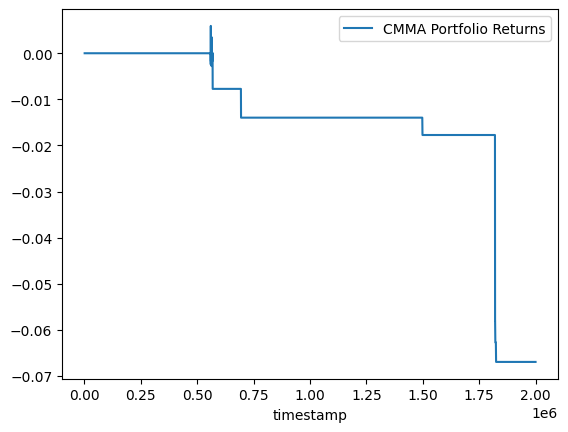

In [174]:
cmma_portfolio = get_portfolio(squid_cmma, 0.9995, 0.0005)
cmma_returns = get_returns(log_ret, cmma_portfolio)
sns.lineplot(data=cmma_returns.cumsum(), label='CMMA Portfolio Returns')

In [164]:
import pandas as pd

positions = cmma_portfolio
changes = (positions != positions.shift()).cumsum()

durations = positions.groupby(changes).size()

avg_holding_time = durations[positions.groupby(changes).first().abs() == 1].mean()

print("Average Holding Time: " , avg_holding_time)


Average Holding Time:  2.979539641943734


In [165]:
def permuted_prices(price_series, block_size, num_permutations):
    """
    Permutes a series of prices by shuffling blocks of log returns.
    
    Parameters:
        price_series (pd.Series): Series of prices.
        block_size (int): The size of the block of log returns to permute.
        num_permutations (int): Number of permuted series to generate.
    
    Returns:
        pd.DataFrame: A dataframe where each column is a permuted price series.
    """
    # Ensure price_series is sorted by index (if it represents time)
    price_series = price_series.sort_index()
    
    # Calculate log prices and log returns
    log_prices = np.log(price_series)
    log_returns = log_prices.diff().dropna()  # drop the first NaN
    
    # Create blocks of log returns
    n = len(log_returns)
    blocks = []
    # We create blocks that are full block_size, plus a remainder block if necessary.
    for i in range(0, n, block_size):
        blocks.append(log_returns.iloc[i:i+block_size].copy())
    
    # Prepare a DataFrame to hold permuted price series
    permuted_df = pd.DataFrame(index=price_series.index)
    permuted_list = []
    # For each permutation
    for p in range(num_permutations):
        # Shuffle the blocks randomly
        shuffled_blocks = blocks.copy()
        np.random.shuffle(shuffled_blocks)
        # Concatenate the shuffled blocks to create a new log return series.
        permuted_log_returns = pd.concat(shuffled_blocks).reset_index(drop=True)
        
        # Reconstruct the permuted log price series.
        # Use the first log price from the original series as the starting point.
        start_value = log_prices.iloc[0]
        permuted_log_prices = pd.concat(
            [pd.Series([start_value]),
             permuted_log_returns.cumsum() + start_value],
            ignore_index=True
        )
        
        # Convert back to price level by exponentiating
        permuted_price_series = np.exp(permuted_log_prices)
        
        # Reindex the permuted price series to match the original series.
        # If the lengths differ (due to the dropped first price), adjust accordingly.
        if len(permuted_price_series) > len(price_series):
            permuted_price_series = permuted_price_series.iloc[:len(price_series)]
        permuted_list.append(permuted_price_series)
    permuted_df = pd.concat(permuted_list, axis=1)
    # Optionally, rename columns if needed:
    permuted_df.columns = [f'perm_{i+1}' for i in range(num_permutations)]
    return permuted_df

def cmma_mcpt(prices, block_size, num_permutations):
    """
    Compute the CMMA and perform Monte Carlo permutation testing.
    
    Parameters:
        prices (pd.Series): Series of prices.
        block_size (int): Size of the blocks for permutation.
        num_permutations (int): Number of permutations to perform.
        lookback (int): Lookback period for CMMA.
    
    Returns:
        pd.DataFrame: DataFrame containing the CMMA and permuted CMMA values.
    """
    base_cmma = cmma(prices, 10)
    base_cmma_portfolio = get_portfolio(base_cmma, 0.76, 0.24)
    base_cmma_returns = get_returns(log_ret, base_cmma_portfolio)
    base_cmma_cum_returns = base_cmma_returns.sum()
    permute_prices = permuted_prices(prices, block_size, num_permutations)
    permuted_log_ret = np.log(permute_prices).diff().dropna()
    permuted_cmma = permute_prices.apply(cmma, lookback=10)
    permuted_cmma_portfolio = permuted_cmma.apply(get_portfolio, args=(0.76, 0.24))
    # permuted_cmma_portfolio = pd.DataFrame([base_cmma_portfolio.values for _ in range(num_permutations)], index=permute_prices.columns).T
    permuted_cmma_returns = permuted_log_ret.multiply(permuted_cmma_portfolio.shift(1)).subtract(permuted_cmma_portfolio.diff().abs() * (1.5/2000))
    permuted_cmma_cum_returns = permuted_cmma_returns.sum()
    print(f'TEST with paramenters: Block size: {block_size}, Num permutations: {num_permutations}')
    print('Base CMMA Cumulative Returns:', base_cmma_cum_returns)
    print('Permuted CMMA Cumulative Returns Mean:', permuted_cmma_cum_returns.mean())
    print('p-value:', (permuted_cmma_cum_returns > base_cmma_cum_returns).sum()/num_permutations)

In [166]:
cmma_mcpt(squid_vwap, 20000, 10)

TEST with paramenters: Block size: 20000, Num permutations: 10
Base CMMA Cumulative Returns: -1.2162490859874842
Permuted CMMA Cumulative Returns Mean: -1.2162490859874844
p-value: 0.0


<Axes: title={'center': 'Permuted Prices'}>

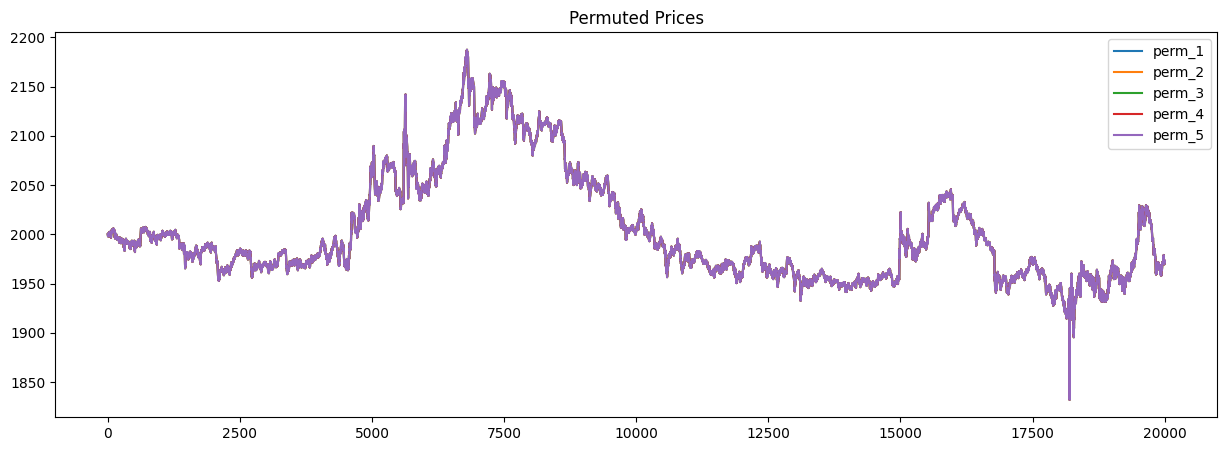

In [167]:
permuted_prices(squid_vwap, 20000, 5).plot(title='Permuted Prices', figsize=(15, 5))

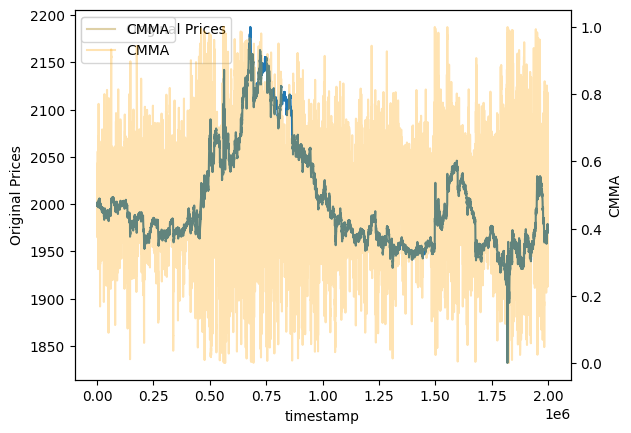

In [168]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax1 = plt.subplots()

# Plot first line on primary y-axis
sns.lineplot(data=squid_vwap, ax=ax1, label='Original Prices')
ax1.set_ylabel('Original Prices')

# Create secondary y-axis
ax2 = ax1.twinx()

# Plot second line on secondary y-axis
sns.lineplot(data=squid_cmma, ax=ax2, label='CMMA', color='orange', alpha = 0.3)
ax2.set_ylabel('CMMA')

# Combine legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.show()
